# Import function

In [1]:
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Import data and split data to training and testing dataset with ShuffleSplit

In [2]:
# normalize labels
def LabelEncoder_data(data):
    typeseries = data.dtypes
    lbl = preprocessing.LabelEncoder()
    for i in typeseries.index:
        if typeseries[i] == 'object':
            data[i] = lbl.fit_transform(data[i].astype(str))
    return data


#  StandardScaler and transforms the data 
def scale_data(unscaled_data):
    scaler = StandardScaler()
    scaler.fit(unscaled_data)
    scaled_data = scaler.transform(unscaled_data)
    return scaled_data


# get features and targets
def target_data(data):
    data_y = data['entertaining'].copy()
    data_x = data.drop('entertaining',axis=1)
    data_x_scaled = scale_data(data_x)
    return data_x_scaled,data_y 

# use StratifiedShuffleSplit to get indices for train and test dataset
from sklearn.model_selection import StratifiedShuffleSplit
def shufflesplit_data(data_x_scaled,data_y):
    # use strat. shuffle split to get indices for test and training data 
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=6)
    sss.get_n_splits(data_x_scaled, data_y)
    return sss


# get train and test dataset from ShuffleSplited data
def train_test_data(sss):
    for train_index, test_index in sss.split(data_x, data_y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = data_x_scaled[train_index], data_x_scaled[test_index]
        y_train, y_test = data_y[train_index], data_y[test_index]
    return x_train,x_test,y_train,y_test


def import_data(data):
    LabelEncodeData=LabelEncoder_data(data)
    data_x_scaled,data_y =target_data(LabelEncodeData)
    return data_x_scaled,data_y 

# Three machine learning algorithms are conducted

## 1. Deicision Tree Classifier

In [3]:
# Find the best max_depth in DecisionTreeClassifier
def finding_maxdepth(data_x_scaled, data_y, sss):
    # array of mean scores with CrossValidation
    ScoreAll=[]

    # estimate max_depth from 2 to 50
    depth = range(2,50,1)

    for d in depth:
        clf_dt = DecisionTreeClassifier(max_depth=d, criterion="gini", random_state=6, splitter="best")
        score = cross_val_score(clf_dt, data_x_scaled, data_y, cv=sss).mean()
        ScoreAll.append([d, score])

    ScoreAll = np.array(ScoreAll)    
    max_score = np.where(ScoreAll == np.max(ScoreAll[:, 1]))[0][0]  
    print("the best depth and the mean score:", ScoreAll[max_score])

    plt.figure(figsize=[8, 4])
    plt.xlabel('Max depth')
    plt.ylabel('Mean score with CrossValidation')
    plt.plot(ScoreAll[:,0], ScoreAll[:,1])
    plt.show()

In [4]:
# find the best min_samples_split
def finding_min_samples_split(data_x_scaled, data_y, sss):
    ScoreAll = []
    
    # estimate min_samples_split from 3 to 15
    for i in range(3, 15):
        clf_dt = tree.DecisionTreeClassifier(min_samples_split=i,criterion='gini',max_depth=14,random_state=6)
        score = cross_val_score(clf_dt, data_x_scaled, data_y, cv=sss).mean()
        ScoreAll.append([i, score])

    ScoreAll = np.array(ScoreAll)
    max_score = np.where(ScoreAll == np.max(ScoreAll[:, 1]))[0][0]  

    print("the best min_samples_split and the mean score:", ScoreAll[max_score])
    plt.figure(figsize=[8, 4])
    plt.xlabel('Min samples split')
    plt.ylabel('Mean score with CrossValidation')
    plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    plt.show()

In [5]:
# find the best min_samples_leaf
def finding_min_samples_leaf(data_x_scaled, data_y,sss):
    ScoreAll = []

    # estimate min_samples_split from 5 to 15
    for i in range(3, 15):
        clf_dt = tree.DecisionTreeClassifier(min_samples_leaf=i,criterion='gini', max_depth=14, min_samples_split=3, \
                                          random_state=6)
        score = cross_val_score(clf_dt,data_x_scaled, data_y, cv=sss).mean()
        ScoreAll.append([i, score])

    ScoreAll = np.array(ScoreAll)
    max_score = np.where(ScoreAll == np.max(ScoreAll[:, 1]))[0][0]  
    print("the best min_samples_leaf and the mean score:", ScoreAll[max_score])
    plt.figure(figsize=[8, 4])
    plt.xlabel('min_samples_leaf')
    plt.ylabel('Mean score with CrossValidation')
    plt.plot(ScoreAll[:, 0], ScoreAll[:, 1])
    plt.show()

In [6]:
# find the best combination of three paramters
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score

def SearchCV():    
    param_grid = {
        'max_depth': np.arange(2, 13),
        'min_samples_leaf': np.arange(3, 10),
        'min_samples_split': np.arange(3, 15)}

    clf_dt = tree.DecisionTreeClassifier(criterion='gini', random_state=6)
    GS = GridSearchCV(clf_dt, param_grid, cv=sss)
    GS.fit(data_x_scaled, data_y)
    print(GS.best_params_)
    print(GS.best_score_)
    max_depth = GS.best_params_['max_depth']
    min_samples_leaf = GS.best_params_['min_samples_leaf']
    min_samples_split = GS.best_params_['min_samples_split']
    return max_depth, min_samples_leaf, min_samples_split

In [7]:
# train the models and get the mean score of cross validation
from sklearn.tree import DecisionTreeClassifier

def Classifier(data_x_scaled, data_y,max_depth,min_samples_leaf,min_samples_split,sss):
    dtc = DecisionTreeClassifier(criterion="gini", random_state=6, splitter="best",max_depth=max_depth,\
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    score_dtc = cross_val_score(dtc, data_x_scaled, data_y, cv=sss)
    print("%0.3f accuracy with a standard deviation of %0.3f" % (score_dtc.mean(), score_dtc.std()))
    return dtc

the best depth and the mean score: [14.          0.67111111]


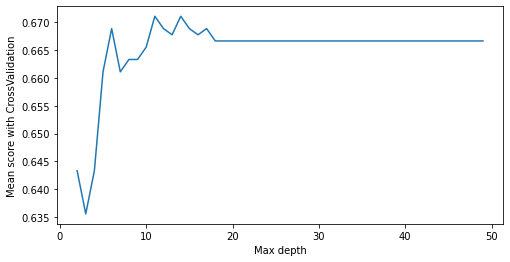

the best min_samples_split and the mean score: [3.         0.68111111]


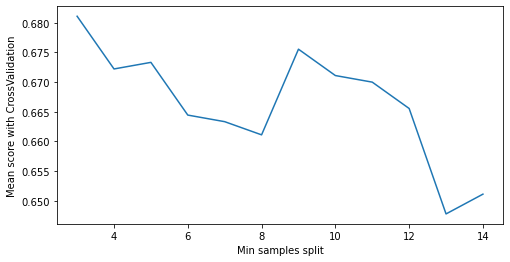

the best min_samples_leaf and the mean score: [5.         0.65777778]


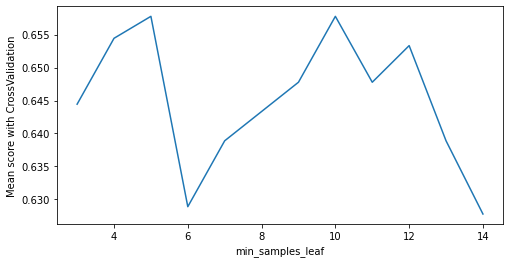

{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 9}
0.6633333333333333
0.663 accuracy with a standard deviation of 0.045


In [8]:
# find the best combination of parameters and analyse the effect of different parameters on mean score
if __name__=='__main__':
    # read audio file
    datafile = 'data/Sample_entertaining.csv' 
    # import audio data
    data_csv = pd.read_csv(datafile, index_col=0,low_memory = False) 
    dataset = data_csv.drop(labels=['uri',"timestamp"],axis=1)
    labels = ['Laughter','ContinBellyLaugh','ContinLaughter',\
        'ContinCheering','ContinApplause','ContinExcitingMusic','ContinSnicker']
    data_x_scaled, data_y  = import_data(dataset)
    
    # shuffle split the dataset
    sss = shufflesplit_data(data_x_scaled, data_y)
    
    # the effect of three parameters on mean score
    finding_maxdepth(data_x_scaled, data_y,sss)
    finding_min_samples_split(data_x_scaled, data_y,sss)
    finding_min_samples_leaf(data_x_scaled, data_y,sss)
    
    # find the best combination of parameters
    max_depth, min_samples_leaf,min_samples_split = SearchCV()
    
    # train model and get the mean score of test dataset
    dtc= Classifier(data_x_scaled,data_y,max_depth,min_samples_leaf,min_samples_split,sss)

### Train Decision Tree classifier with the best combination of parameters and evaluate the performance of the model

In [9]:
x_train,x_test,y_train,y_test = train_test_split(data_x_scaled, data_y,test_size = 0.3,random_state =5)

training accuracy (depth: 2 ): 0.719047619047619
test accuracy (depth: 2 ): 0.7
training accuracy (depth: 3 ): 0.7380952380952381
test accuracy (depth: 3 ): 0.6888888888888889
training accuracy (depth: 4 ): 0.7571428571428571
test accuracy (depth: 4 ): 0.6666666666666666
training accuracy (depth: 5 ): 0.8095238095238095
test accuracy (depth: 5 ): 0.6666666666666666
training accuracy (depth: 6 ): 0.8142857142857143
test accuracy (depth: 6 ): 0.6444444444444445
training accuracy (depth: 7 ): 0.8238095238095238
test accuracy (depth: 7 ): 0.7444444444444445
training accuracy (depth: 8 ): 0.8380952380952381
test accuracy (depth: 8 ): 0.7555555555555555
training accuracy (depth: 9 ): 0.8428571428571429
test accuracy (depth: 9 ): 0.7444444444444445
training accuracy (depth: 10 ): 0.8428571428571429
test accuracy (depth: 10 ): 0.7111111111111111
training accuracy (depth: 11 ): 0.8428571428571429
test accuracy (depth: 11 ): 0.7222222222222222
training accuracy (depth: 12 ): 0.8428571428571429
t

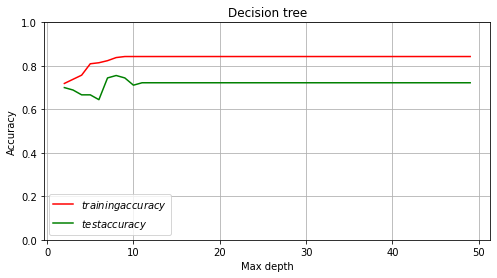

In [10]:
# analyse the effect of max_depth on the score of trainning and testing
from sklearn.tree import DecisionTreeClassifier
train_accuracy = []
test_accuracy = []

depth = range(2,50,1)
for d in depth:
    dtc = DecisionTreeClassifier(max_depth= d,criterion="gini",random_state=5,splitter="best",min_samples_split=9,min_samples_leaf=4)
    dtc.fit(x_train, y_train)
    
    train_score = dtc.score(x_train, y_train)
    train_accuracy.append(train_score)
    print('training accuracy (depth:',d,'):',train_score)
    
    test_score = dtc.score(x_test, y_test)
    test_accuracy.append(test_score)
    print('test accuracy (depth:',d,'):',test_score)

plt.figure(figsize=(8,4))
plt.plot(depth,train_accuracy,label='$training accuracy$',color='red')
plt.plot(depth,test_accuracy,label='$test accuracy$',color='green')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.ylim((0, 1))
plt.title('Decision tree')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# train Decision Tree model
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion="gini",random_state=5,splitter="best",max_depth=6,\
                             min_samples_split=9,min_samples_leaf=4)
dtc.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=9,
                       random_state=5)

In [12]:
# get the graph of Decision Tree
from six import StringIO
import pydot

dot_data = StringIO()
feature_name = ['Laughter','ContinBellyLaugh','ContinLaughter','ContinGiggle','ContinCheering',\
            'ContinApplause','ContinExcitingMusic']
class_name = ['funny', 'neutral']

graph_data = tree.export_graphviz(dtc, out_file=dot_data,\
                                feature_names=feature_name, class_names=class_name,\
                                filled=True, rounded=True, special_characters=True) 
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())
graph.write_png('EntertainingTreePlot.png')

Text(0.5, 1.0, 'confusion matrix of test')

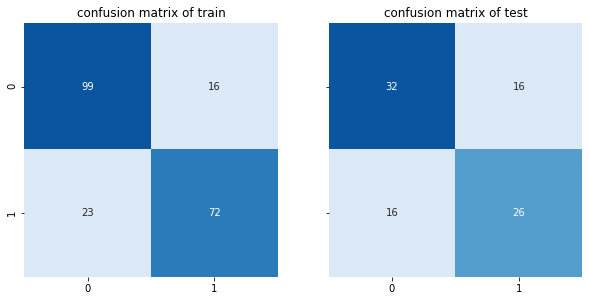

In [13]:
# the confusion matrix of train and test dataset
import matplotlib.pyplot as plt
import seaborn as sns
cn_tc_train = confusion_matrix(y_train, dtc.predict(x_train))
cn_tc_test = confusion_matrix(y_test, dtc.predict(x_test))

%matplotlib inline
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,10))

g1 = sns.heatmap(cn_tc_train, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f', ax=ax1,square=True,cbar=False)
g2 = sns.heatmap(cn_tc_test, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f',ax=ax2,square=True,cbar=False)

ax1.set_title('confusion matrix of train')
ax2.set_title('confusion matrix of test')

In [14]:
# the report of training and testing results
print(classification_report(y_train,dtc.predict(x_train)))
print('----------------------------------------------------------')
print(classification_report(y_test,dtc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       115
           1       0.82      0.76      0.79        95

    accuracy                           0.81       210
   macro avg       0.81      0.81      0.81       210
weighted avg       0.81      0.81      0.81       210

----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        48
           1       0.62      0.62      0.62        42

    accuracy                           0.64        90
   macro avg       0.64      0.64      0.64        90
weighted avg       0.64      0.64      0.64        90



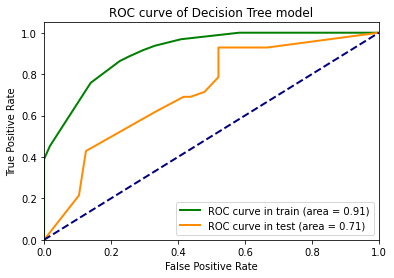

In [15]:
# the ROC curve of training and testing dataset
from sklearn.metrics import roc_curve

y_score_train_dtc = dtc.predict_proba(x_train)
fpr_train_dtc, tpr_train_dtc, _ = roc_curve(y_train, y_score_train_dtc[:,1])
y_score_test_dtc = dtc.predict_proba(x_test)
fpr_test_dtc, tpr_test_dtc, _ = roc_curve(y_test, y_score_test_dtc[:,1])

plt.figure()
lw = 2
roc_auc_train_dtc = auc(fpr_train_dtc, tpr_train_dtc)
roc_auc_test_dtc = auc(fpr_test_dtc, tpr_test_dtc)
plt.plot(fpr_train_dtc, tpr_train_dtc, color='green',lw=lw, 
             label='ROC curve in train (area = %0.2f)' % roc_auc_train_dtc)
plt.plot(fpr_test_dtc, tpr_test_dtc, color='darkorange',lw=lw, 
             label='ROC curve in test (area = %0.2f)' % roc_auc_test_dtc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')

plt.xlim([0, 1.0])
plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Decision Tree model')
plt.legend(loc="lower right")
plt.show()  


## 2、Randrom Forest Classifier

In [16]:
# find the best combination of max_depth and n_estimators
def finding_parameter(data_x_scaled, data_y, sss):
    # set the range of finding estimator_number and max_depth
    estimator_number = np.arange(12,30,1)
    depth = np.arange(3,20,1)
    ScoreAll=[]
    Scorenum=[]
    Scorenum_array=[]
    for num in estimator_number:
        Scorenum=[]
        for d in depth:
            clf = RandomForestClassifier(n_estimators=num, max_depth=d,random_state=6,oob_score=True,\
                                         criterion='gini',max_features='sqrt')
            score = cross_val_score(clf, data_x_scaled, data_y, cv=sss).mean()
            ScoreAll.append([d, num, score])
            Scorenum.append(score)
        Scorenum_array.append(np.array(Scorenum))
   
    ScoreAll = np.array(ScoreAll) 
    # get the position of the best combination and the score
    max_score = np.where(ScoreAll == np.max(ScoreAll[:, 2]))  
    print("the best depth, the best estimator_number and the score:", ScoreAll[max_score[0],0],ScoreAll[max_score[0],1],ScoreAll[max_score])

    f, ax = plt.subplots(1, 1, figsize=(24, 10))
    cax = ax.matshow( Scorenum_array, interpolation='nearest')
    f.colorbar(cax)
    ax.set_xticks(range(0,len(depth)))
    ax.set_yticks(range(0,len(estimator_number)))
    ax.set_xticklabels(depth.tolist()) 
    ax.set_yticklabels(estimator_number.tolist())
    plt.xlabel('max depth')
    plt.ylabel('estimator_number')
    plt.show()


In [17]:
# GridSearchCV to find the best combination of max_depth and n_estimators
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score

def SearchCV(data_x_scaled, data_y):  
    param_grid = {
        'max_depth': np.arange(5, 18),
        'n_estimators': np.arange(12, 30),
        }
    clf_rf = RandomForestClassifier(random_state=6,oob_score=True,criterion='gini',max_features='sqrt')
    
    # use GredSearchCV to find the best combination of parameters
    GS = GridSearchCV(clf_rf, param_grid, cv=sss)
    GS.fit(data_x_scaled, data_y)
    print(GS.best_params_)
    print(GS.best_score_)
    max_depth = GS.best_params_['max_depth']
    n_estimators = GS.best_params_['n_estimators']
 
    return max_depth, n_estimators

In [19]:
# train model and get the mean score of cross validation
from sklearn.tree import DecisionTreeClassifier

def RF_Classifier(data_x_scaled, data_y,max_depth,n_estimators,sss):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,\
                                      random_state=6,oob_score=True,criterion='gini',max_features='sqrt')
    score_rf = cross_val_score(rf, data_x_scaled, data_y, cv=sss)
    print("%0.3f accuracy with a standard deviation of %0.3f" % (score_rf.mean(), score_rf.std()))
    return rf

the best depth, the best estimator_number and the score: [17.  7.  8.  8.] [18. 24. 25. 29.] [0.70333333 0.70333333 0.70333333 0.70333333]


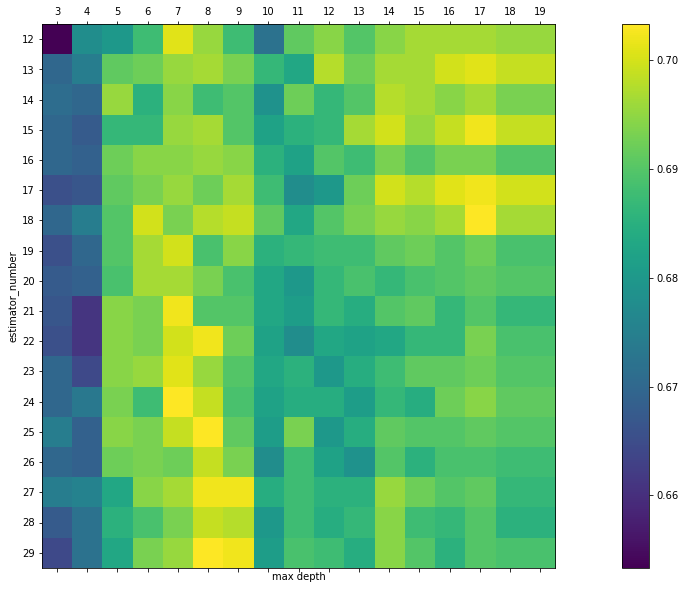

{'max_depth': 7, 'n_estimators': 24}
0.7033333333333334
0.703 accuracy with a standard deviation of 0.032


In [20]:
# find the best combination of parameters and analyse the effect of different parameters on mean score
if __name__=='__main__':
    # read audio file
    datafile = 'data/data_labelled_entertainment.csv' 
    # import audio data
    data_csv = pd.read_csv(datafile, index_col=0,low_memory = False) 
    dataset = data_csv.drop(labels=['uri',"timestamp"],axis=1)
    labels = ['Laughter','ContinBellyLaugh','ContinLaughter','ContinGiggle',\
        'ContinCheering','ContinApplause','ContinExcitingMusic']
    data_x_scaled, data_y  = import_data(dataset)
    
    # shuffle split the dataset
    sss = shufflesplit_data(data_x_scaled, data_y)
    finding_parameter(data_x_scaled, data_y, sss)
    max_depth, n_estimators = SearchCV(data_x_scaled, data_y)
    
    # train model and get the mean score of test dataset
    rf= RF_Classifier(data_x_scaled,data_y,max_depth,n_estimators,sss)

### Train Random Forest classifier with the best combination of parameters and get the performance of the model

In [21]:
x_train,x_test,y_train,y_test = train_test_split(data_x_scaled, data_y,test_size = 0.3,random_state = 5)

training accuracy (depth: 2 ): 0.7
test accuracy (depth: 2 ): 0.6666666666666666
training accuracy (depth: 3 ): 0.7285714285714285
test accuracy (depth: 3 ): 0.7
training accuracy (depth: 4 ): 0.8238095238095238
test accuracy (depth: 4 ): 0.7777777777777778
training accuracy (depth: 5 ): 0.8523809523809524
test accuracy (depth: 5 ): 0.7444444444444445
training accuracy (depth: 6 ): 0.8904761904761904
test accuracy (depth: 6 ): 0.7333333333333333
training accuracy (depth: 7 ): 0.9
test accuracy (depth: 7 ): 0.7222222222222222
training accuracy (depth: 8 ): 0.9047619047619048
test accuracy (depth: 8 ): 0.7333333333333333
training accuracy (depth: 9 ): 0.9142857142857143
test accuracy (depth: 9 ): 0.7555555555555555
training accuracy (depth: 10 ): 0.919047619047619
test accuracy (depth: 10 ): 0.7444444444444445
training accuracy (depth: 11 ): 0.919047619047619
test accuracy (depth: 11 ): 0.7222222222222222
training accuracy (depth: 12 ): 0.919047619047619
test accuracy (depth: 12 ): 0.7
t

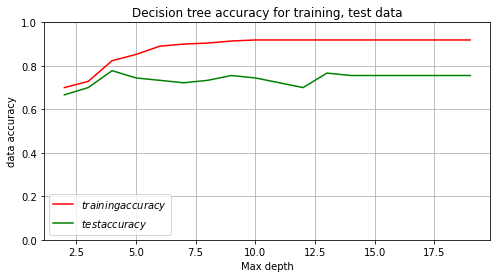

In [22]:
# analyse the effect of max_depth on the score of trainning and testing
depth = range(2,20,1)
train_accuracy = []
test_accuracy = []
for d in depth:
    model_dt = RandomForestClassifier(n_estimators=24, max_depth=d,random_state=5,\
                                      oob_score=True,criterion='gini',max_features='sqrt')
    model_dt.fit(x_train, y_train)
    
    train_score = model_dt.score(x_train, y_train)
    train_accuracy.append(train_score)
    print('training accuracy (depth:',d,'):',train_score)

    test_score = model_dt.score(x_test, y_test)
    test_accuracy.append(test_score)
    print('test accuracy (depth:',d,'):',test_score)
    
plt.figure(figsize=(8,4))
plt.plot(depth,train_accuracy,label='$training accuracy$',color='red')
plt.plot(depth,test_accuracy,label='$test accuracy$',color='green')
plt.xlabel('Max depth')
plt.ylabel('data accuracy')
plt.ylim((0, 1))
plt.title('Decision tree accuracy for training, test data')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# train the model
print("random forest")
rfc = RandomForestClassifier(n_estimators=24, max_depth=7,random_state=5,oob_score=True,criterion='gini',max_features='sqrt')
rfc.fit(x_train, y_train)

random forest


RandomForestClassifier(max_depth=7, max_features='sqrt', n_estimators=24,
                       oob_score=True, random_state=5)

Text(0.5, 1.0, 'confusion matrix of test')

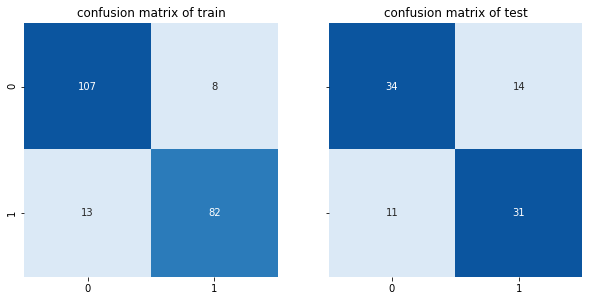

In [24]:
# the confusion matrix of train and test dataset
import matplotlib.pyplot as plt
import seaborn as sns
cn_tc_train = confusion_matrix(y_train, rfc.predict(x_train))
cn_tc_test = confusion_matrix(y_test, rfc.predict(x_test))

%matplotlib inline
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,10))

g1 = sns.heatmap(cn_tc_train, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f', ax=ax1,square=True,cbar=False)
g2 = sns.heatmap(cn_tc_test, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f',ax=ax2,square=True,cbar=False)

ax1.set_title('confusion matrix of train')
ax2.set_title('confusion matrix of test')

In [25]:
# the report of training and testing results
from sklearn.metrics import classification_report

print(classification_report(y_train,rfc.predict(x_train)))
print('----------------------------------------------------------')
print(classification_report(y_test,rfc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       115
           1       0.91      0.86      0.89        95

    accuracy                           0.90       210
   macro avg       0.90      0.90      0.90       210
weighted avg       0.90      0.90      0.90       210

----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.71      0.73        48
           1       0.69      0.74      0.71        42

    accuracy                           0.72        90
   macro avg       0.72      0.72      0.72        90
weighted avg       0.72      0.72      0.72        90



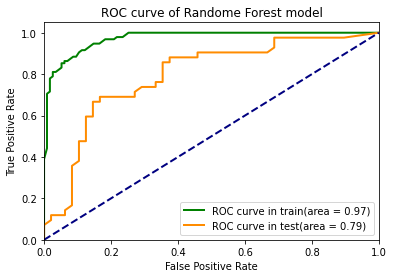

In [26]:
# the ROC curve of training and testing dataset
from sklearn.metrics import roc_curve
y_score_train_rfc = rfc.predict_proba(x_train)
fpr_train_rfc, tpr_train_rfc, _ = roc_curve(y_train, y_score_train_rfc[:,1])
y_score_test_rfc = rfc.predict_proba(x_test)
fpr_test_rfc, tpr_test_rfc, _ = roc_curve(y_test, y_score_test_rfc[:,1])

plt.figure()
lw = 2
# get the ROC of train
roc_auc_train_rfc = auc(fpr_train_rfc, tpr_train_rfc)
# get the ROC of test
roc_auc_test_rfc = auc(fpr_test_rfc, tpr_test_rfc)
# plot
plt.plot(fpr_train_rfc, tpr_train_rfc, color='green',lw=lw, 
             label='ROC curve in train(area = %0.2f)' % roc_auc_train_rfc)
plt.plot(fpr_test_rfc, tpr_test_rfc, color='darkorange',lw=lw, 
             label='ROC curve in test(area = %0.2f)' % roc_auc_test_rfc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')

plt.xlim([0, 1.0])
plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Randome Forest model')
plt.legend(loc="lower right")
plt.show()  

## 3. SVM

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC

CScale = range(-15,15,1)
gammaScale = range(-15,15,1)

CScale = [2 ** i for i in CScale]
gammaScale = [2 ** i for i in gammaScale]

parameters = dict(kernel=['rbf'],gamma=gammaScale, C=CScale)
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=6)
SVC=svm.SVC(decision_function_shape='ovo',probability=True, class_weight='balanced',random_state=6)

svm = GridSearchCV(estimator=SVC, param_grid=parameters, cv=sss,n_jobs=-1)
svm.fit(data_x_scaled, data_y)

print('The parameters of the best model are: ')
print(svm.best_params_)
print('The best score is: ')
print(svm.best_score_ )
print('The mean score is: ')
print(cross_val_score(svm, data_x_scaled, data_y, cv=sss).mean())

The parameters of the best model are: 
{'C': 4, 'gamma': 0.125, 'kernel': 'rbf'}
The best score is: 
0.6944444444444445
The mean score is: 
0.6477777777777778


### Use the parameters to train SVM model and get the performance of the model

In [28]:
# split data to train dataset and test dataset
x_train,x_test,y_train,y_test = train_test_split(data_x_scaled, data_y, test_size =0.3, random_state=5)

In [29]:
print("SVM Classifier")
from sklearn import svm

svm_clf = svm.SVC(kernel='rbf', C=4, gamma=0.125, probability=True, class_weight='balanced',random_state=5)
svm_clf.fit(x_train,y_train)

SVM Classifier


SVC(C=4, class_weight='balanced', gamma=0.125, probability=True, random_state=5)

Text(0.5, 1.0, 'confusion matrix of test')

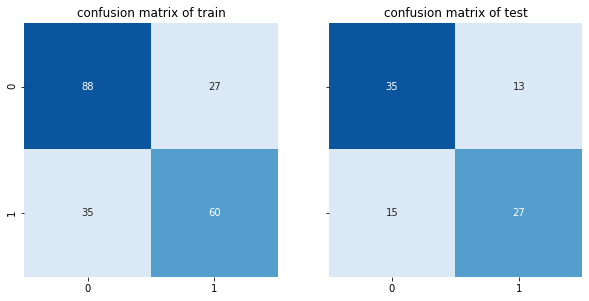

In [31]:
# the confusion matrix of train and test dataset
import matplotlib.pyplot as plt
import seaborn as sns
cn_tc_train = confusion_matrix(y_train, svm_clf.predict(x_train))
cn_tc_test = confusion_matrix(y_test, svm_clf.predict(x_test))

%matplotlib inline
f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,10))

g1 = sns.heatmap(cn_tc_train, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f', ax=ax1,square=True,cbar=False)
g2 = sns.heatmap(cn_tc_test, cmap = sns.color_palette("Blues"), annot=True,fmt='.0f',ax=ax2,square=True,cbar=False)

ax1.set_title('confusion matrix of train')
ax2.set_title('confusion matrix of test')

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_train,svm_clf.predict(x_train)))
print('----------------------------------------------------------')
print(classification_report(y_test,svm_clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       115
           1       0.69      0.63      0.66        95

    accuracy                           0.70       210
   macro avg       0.70      0.70      0.70       210
weighted avg       0.70      0.70      0.70       210

----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.73      0.71        48
           1       0.68      0.64      0.66        42

    accuracy                           0.69        90
   macro avg       0.69      0.69      0.69        90
weighted avg       0.69      0.69      0.69        90



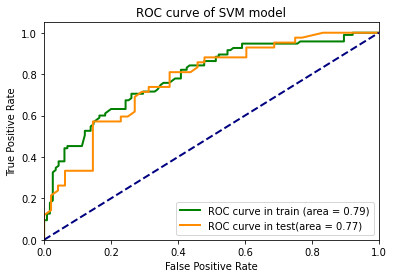

In [32]:
from sklearn.metrics import roc_curve
y_score_train_svm = svm_clf .predict_proba(x_train)
fpr_train_svm, tpr_train_svm, _ = roc_curve(y_train, y_score_train_svm[:,1])
y_score_test_svm = svm_clf .predict_proba(x_test)
fpr_test_svm, tpr_test_svm, _ = roc_curve(y_test, y_score_test_svm[:,1])

plt.figure()
lw = 2
# get the ROC of train dataset
roc_auc_train_svm = auc(fpr_train_svm,tpr_train_svm)
# get the ROC of test dataset
roc_auc_test_svm = auc(fpr_test_svm,tpr_test_svm)
# plot
plt.plot(fpr_train_svm, tpr_train_svm, color='green',lw=lw, 
             label='ROC curve in train (area = %0.2f)' % roc_auc_train_svm)
plt.plot(fpr_test_svm, tpr_test_svm, color='darkorange',lw=lw, 
             label='ROC curve in test(area = %0.2f)' % roc_auc_test_svm)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')

plt.xlim([0, 1.0])
plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of SVM model')
plt.legend(loc="lower right")
plt.show()  


## Compare the AUC ROC of the three models

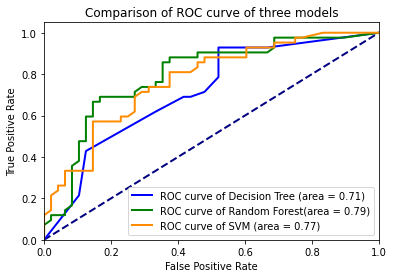

In [39]:
from sklearn.metrics import roc_curve

plt.figure()
lw = 2
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')

plt.plot(fpr_test_dtc, tpr_test_dtc, color='blue',lw=lw, 
             label='ROC curve of Decision Tree (area = %0.2f)' % roc_auc_test_dtc)
plt.plot(fpr_test_rfc, tpr_test_rfc, color='green',lw=lw, 
             label='ROC curve of Random Forest(area = %0.2f)' % roc_auc_test_rfc)
plt.plot(fpr_test_svm, tpr_test_svm, color='darkorange',lw=lw, 
             label='ROC curve of SVM (area = %0.2f)' % roc_auc_test_svm)

plt.xlim([0, 1.0])
plt.ylim([0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC curve of three models')
plt.legend(loc="lower right")
plt.show()  

# Compare the precisions of the three models

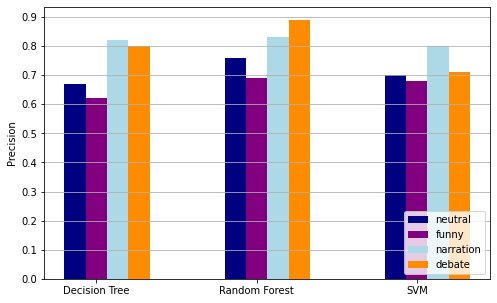

In [42]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
 
name_list = ['Decision Tree','Random Forest','SVM']
num_list = [0.67,0.76,0.70]
num_list1 = [0.62,0.69,0.68]
num_list2 = [0.82,0.83,0.80]
num_list3 = [0.80,0.89,0.71]
x =list(range(len(num_list)))
total_width, n = 0.8, 6
width = total_width / n
plt.bar(x, num_list, width=width, label='neutral',fc = 'navy')


for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list1, width=width, label='funny',tick_label = name_list,fc = 'purple')

for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list2, width=width, label='narration',fc = 'lightblue')


for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list3, width=width, label='debate',fc = 'darkorange')

ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.grid(True, which='major')
plt.legend(loc='lower right', fontsize=10)
plt.ylabel('Precision')
plt.show()


# Compare the recalls of the three models

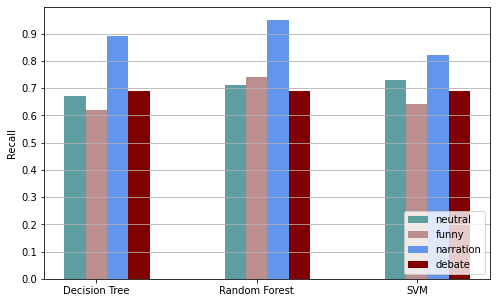

In [41]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
 
name_list = ['Decision Tree','Random Forest','SVM']
num_list = [0.67,0.71,0.73]
num_list1 = [0.62,0.74,0.64]
num_list2 = [0.89,0.95,0.82]
num_list3 = [0.69,0.69,0.69]
x =list(range(len(num_list)))
total_width, n = 0.8, 6
width = total_width / n
plt.bar(x, num_list, width=width, label='neutral',fc = 'cadetblue')


for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list1, width=width, label='funny',tick_label = name_list,fc = 'rosybrown')

for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list2, width=width, label='narration',fc = 'cornflowerblue')


for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list3, width=width, label='debate',fc = 'maroon')

ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.grid(True, which='major')
plt.legend(loc='lower right', fontsize=10)
plt.ylabel('Recall')
plt.show()
